In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from matplotlib.pyplot import figure
from pathlib import Path
from sklearn.metrics import plot_confusion_matrix

In [2]:
data_path = Path('../anes-data')
figures_path = Path('../figures')

In [3]:
intubs = pd.read_csv(data_path / 'intubs.csv')
ptx_info_dose = pd.read_csv(data_path / 'ptx-info-dose.csv')
outcome_vitals = pd.read_csv(data_path / 'outcome_vitals.csv')
ptx_info = pd.read_csv(data_path / 'ptx-info.csv')
avg_vitals = pd.read_csv(data_path / 'avg_vitals.csv')
pt_drug_x = pd.read_csv(data_path / 'pt_drug_x.csv')
intubes_pt_info = pd.read_csv(data_path / 'intubes_pt_info.csv')

In [4]:
outcome_vitals = outcome_vitals.drop(['sbp_ni', 'dbp_ni', 'mbp_ni'], axis=1)
avg_vitals = avg_vitals.drop(['avg_sbp_ni', 'avg_dbp_ni', 'avg_mbp_ni'], axis=1)

In [5]:
source = (intubes_pt_info
        .drop('subject_id', axis=1)
        .set_index('stay_id')
        .join(avg_vitals.drop('subject_id', axis=1)
        .set_index('stay_id'), how='inner')
        .reset_index()
        .drop(['hadm_id'], axis=1)
        .set_index('stay_id')
        .join(avg_vitals[['subject_id', 'stay_id']]
        .set_index('stay_id'))
        .join(intubs.set_index('stay_id')['patientweight'])
        .drop_duplicates())

In [6]:
drugs = ["Furosemide",
"Metoprolol Tartrate",
"Propofol",
"Fentanyl Citrate",
"Lorazepam",
"HYDROmorphone (Dilaudid)",
"Haloperidol",
"Nitroglycerin",
"Midazolam",
"PHENYLEPHrine",
"NORepinephrine"]

In [7]:
drugs = set(pt_drug_x.medication) & set(drugs)
dosage = ptx_info_dose[ptx_info_dose.medication.isin(drugs)][['subject_id', 'stay_id', 'medication', 'dose_given', 'dose_given_unit']].dropna()

In [9]:
encoded_ptx_drugs = pd.get_dummies(pt_drug_x.set_index('stay_id').medication)[drugs].reset_index().groupby('stay_id').sum()

In [10]:
source2 = source.join(encoded_ptx_drugs, how='left').drop_duplicates().drop(['avg_sbp', 'avg_dbp'], axis=1)

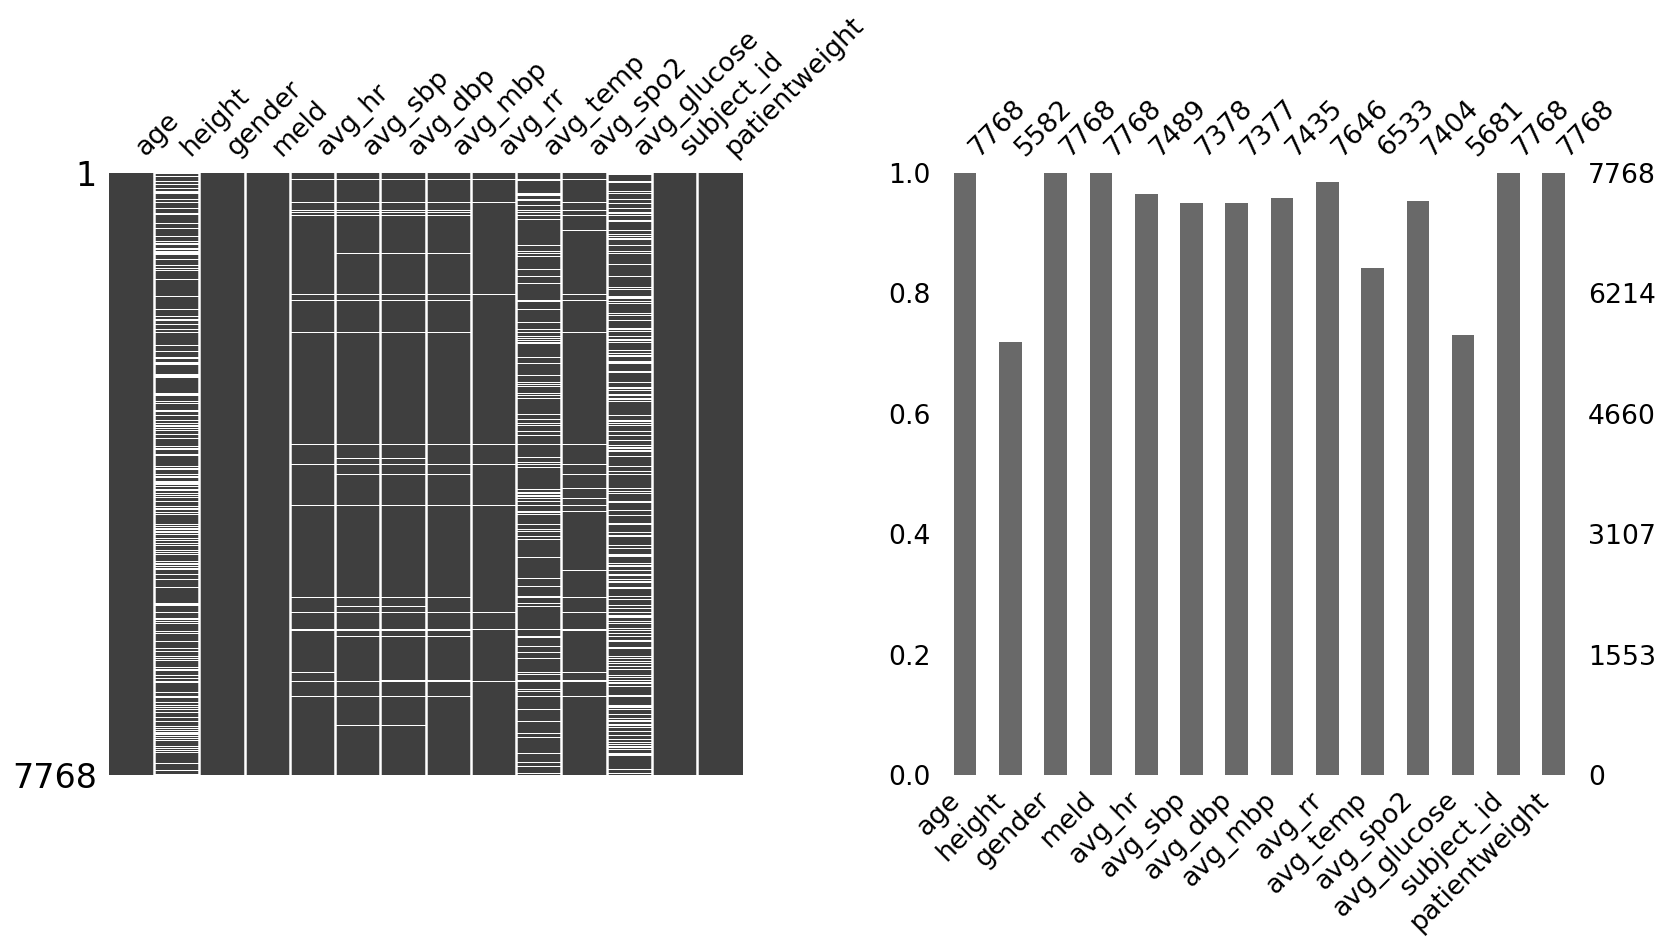

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(14, 8), dpi=120)
msno.matrix(source, ax=axes[0])
msno.bar(source, ax=axes[1])
plt.tight_layout()
plt.savefig(figures_path / 'missing_data.png', dpi=120)
plt.show()

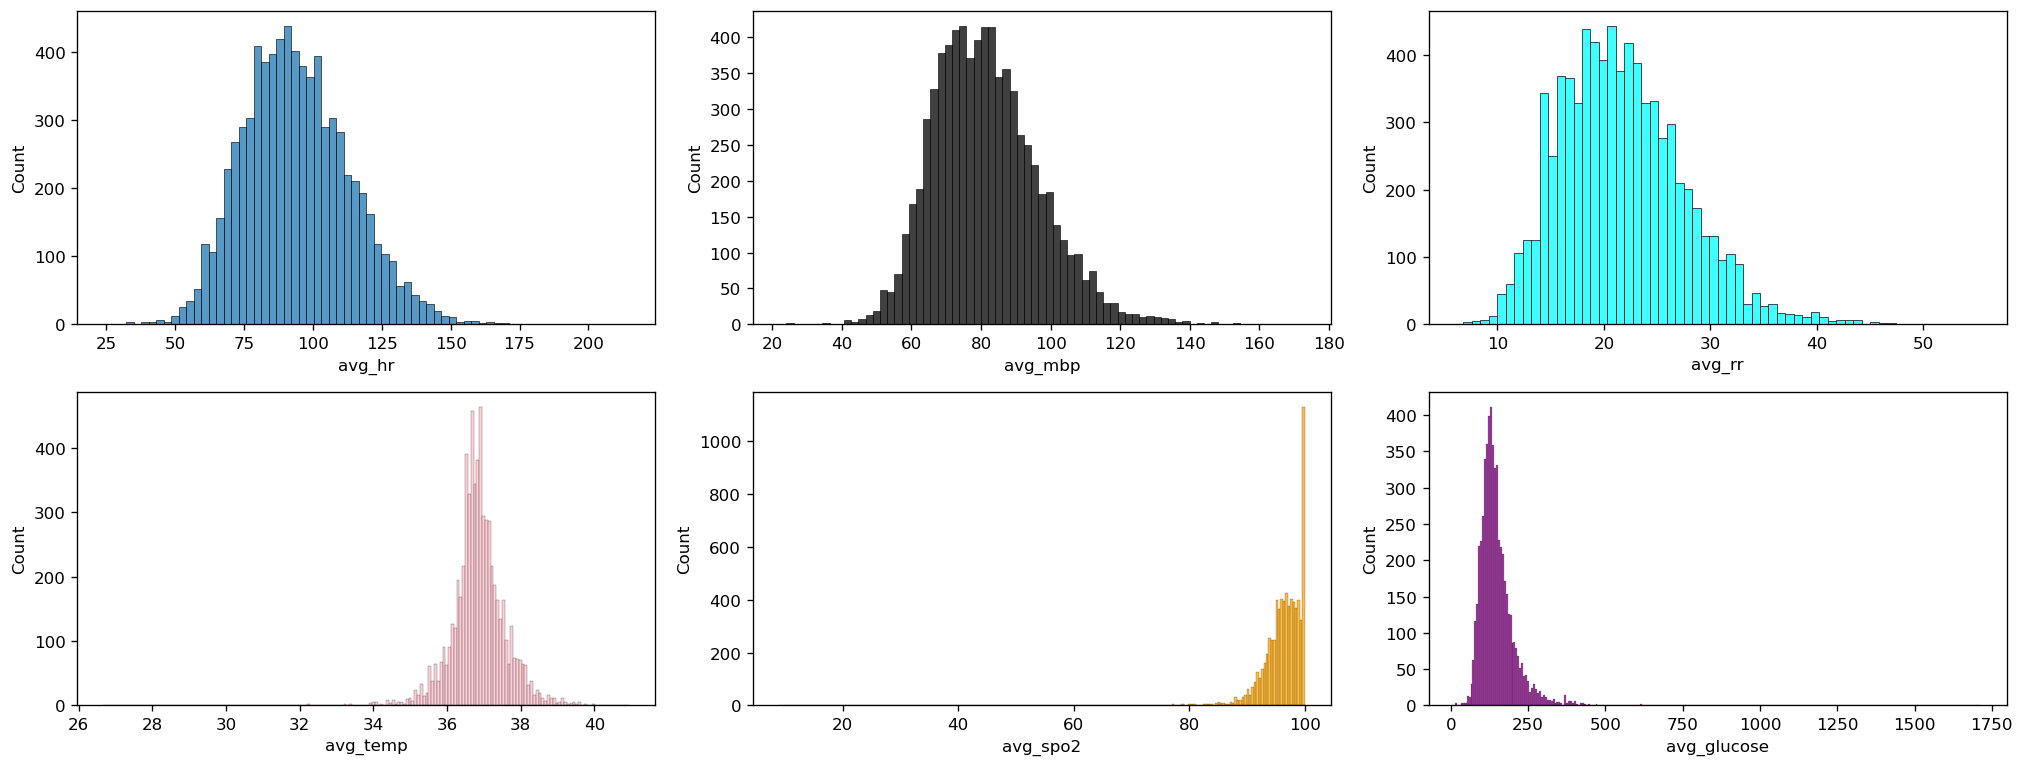

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(17, 6.5), dpi=120)

sns.histplot(data=source, x='avg_hr', ax=axes[0][0])
sns.histplot(data=source, x='avg_mbp', ax=axes[0][1], color='black')
sns.histplot(data=source, x='avg_rr', ax=axes[0][2], color='cyan')
sns.histplot(data=source, x='avg_temp', ax=axes[1][0], color='pink')
sns.histplot(data=source, x='avg_spo2', ax=axes[1][1], color='orange')
sns.histplot(data=source, x='avg_glucose', ax=axes[1][2], color='purple')
plt.tight_layout()
plt.savefig(figures_path / 'vitals_distribution.png', dpi=120)
plt.show()

<Figure size 360x360 with 0 Axes>

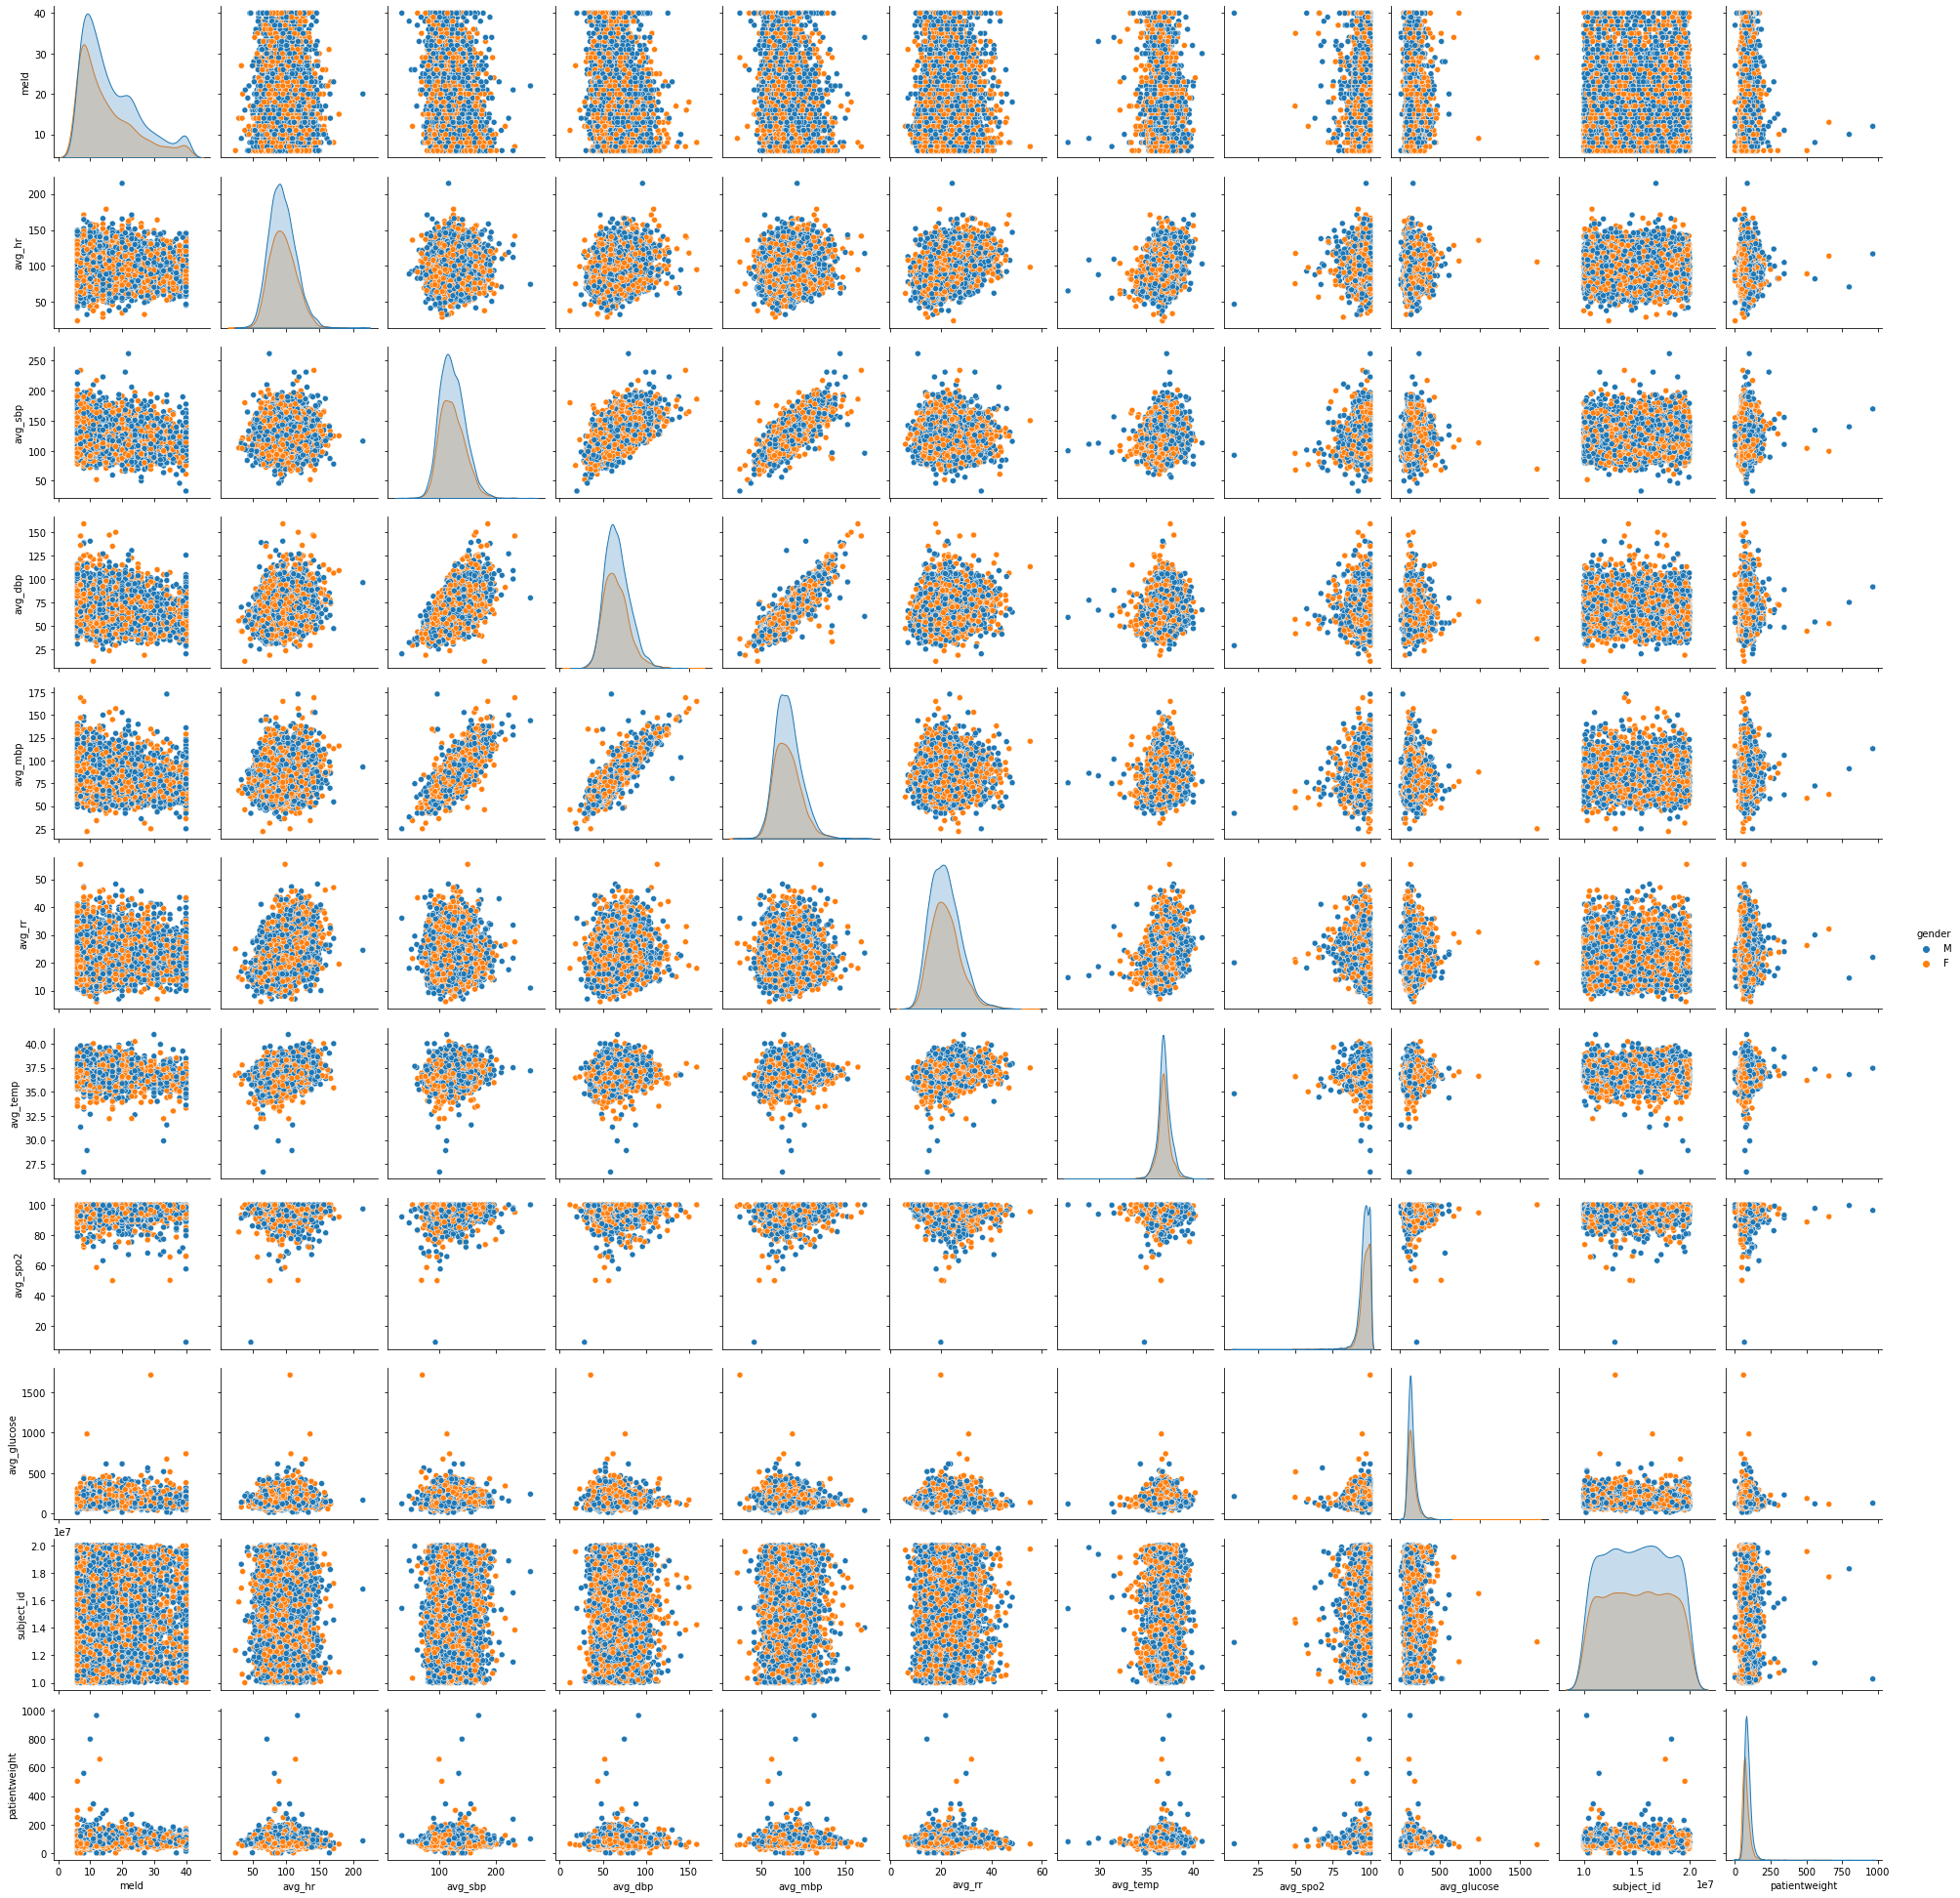

In [13]:
figure(figsize=(3, 3), dpi=120)
sns.pairplot(source[source.columns[2:]], hue='gender')
plt.savefig(figures_path / 'pairplot.png', dpi=120)
plt.show()

In [14]:
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error

In [15]:
source2 = source.join(encoded_ptx_drugs, how='left').drop_duplicates().drop(['avg_sbp', 'avg_dbp'], axis=1).reset_index()

In [16]:
drugs = list(drugs)

In [17]:
source2[drugs] = source2[drugs].fillna(value=0)

In [18]:
def get_event(avg_hr, avg_mbp, avg_rr, avg_spo2, avg_glucose):
    hr = False
    rr = False
    spo2 = False
    gluc = False
    
    if avg_hr < 60 or avg_hr > 110:
        hr = True
    if avg_rr < 10:
        rr = True
    if avg_spo2 < 85:
        spo2 = True
#     if avg_glucose < 100:
#         gluc = True
        
    if any([hr, rr, spo2, gluc]): return 1
    else: return 0

In [19]:
dosage['encoded_dose'] = dosage.apply(lambda x: f'{x.medication}_{x.dose_given}_{x.dose_given_unit}', axis=1)

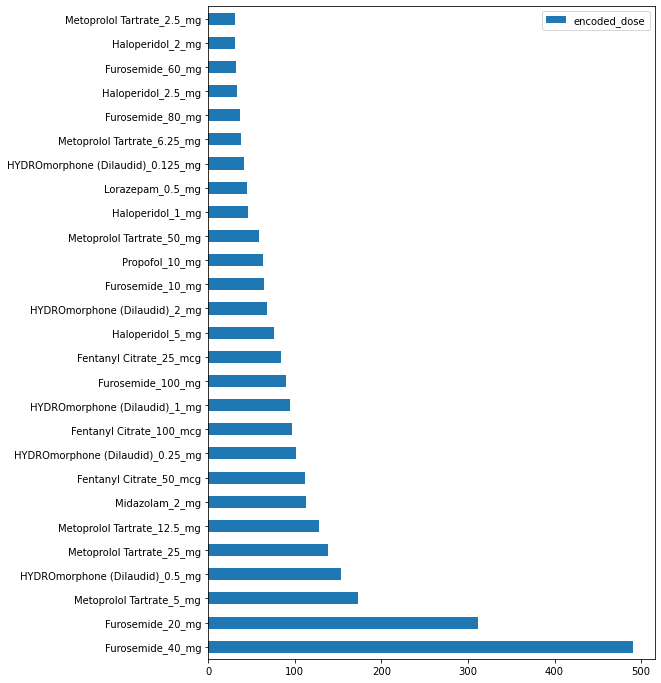

In [20]:
pd.DataFrame(dosage['encoded_dose'].value_counts()).loc[[k for k, v in dict(dosage['encoded_dose'].value_counts(normalize=True) >= 0.01).items() if v]].plot(kind='barh', figsize=(8, 12))
plt.show()

In [21]:
source2 = source.join(dosage.set_index('stay_id').drop('subject_id', axis=1)['encoded_dose']).drop_duplicates()
source2 = source2.join(pd.get_dummies(source2.gender)).drop('gender', axis=1)

In [22]:
source2 = source2.join(pd.get_dummies(source2['encoded_dose']).reset_index().groupby('stay_id').sum().applymap(lambda x: 1 if x > 0 else 0)).drop('encoded_dose', axis = 1)

In [23]:
source2['BMI'] = source2['patientweight'] / source2['height']

In [24]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.linear_model import LogisticRegression
import sklearn

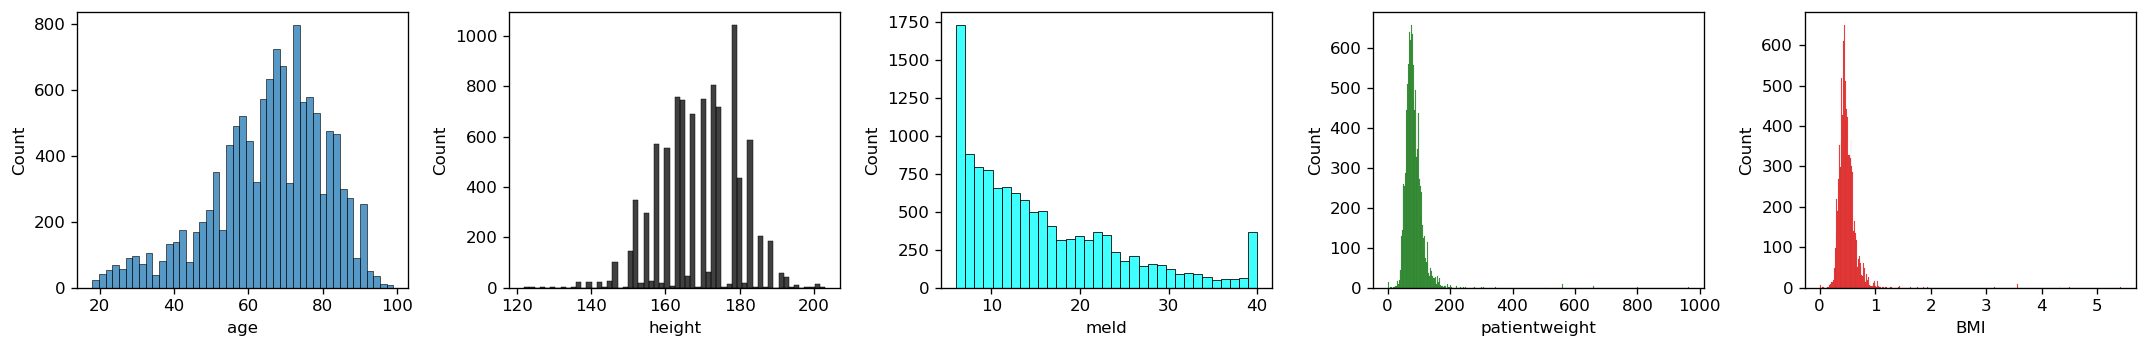

In [25]:
fig, axes = plt.subplots(1, 5, figsize=(18, 3), dpi=120)

sns.histplot(data=source2, x='age', ax=axes[0])
sns.histplot(data=source2, x='height', ax=axes[1], color='black')
sns.histplot(data=source2, x='meld', ax=axes[2], color='cyan')
sns.histplot(data=source2, x='patientweight', ax=axes[3], color='green')
sns.histplot(data=source2, x='BMI', ax=axes[4], color='red')
plt.tight_layout()
plt.savefig(figures_path / 'patient_attrs.png', dpi=120)
plt.show()

In [26]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import  RandomOverSampler

In [27]:
X = source2.drop(['subject_id', 'avg_hr', 'avg_sbp', 'avg_dbp', 'avg_mbp', 'avg_rr', 'avg_temp', 'avg_spo2', 'avg_glucose'], axis=1)
y = source2[['avg_hr', 'avg_mbp', 'avg_rr', 'avg_spo2', 'avg_glucose']].apply(lambda x: get_event(x.avg_hr, x.avg_mbp, x.avg_rr, x.avg_spo2, x.avg_glucose), axis=1)

In [31]:
under_sampler = RandomUnderSampler()
over_sampler = RandomOverSampler()
# X, y = over_sampler.fit_resample(X, y)

In [29]:
Counter(y)

Counter({0: 9333, 1: 2915})

In [47]:
%%time

params = {
    'n_estimators': 620,
    'max_depth': 11,
    'learning_rate': 0.05569188794654985,
    'subsample': 0.6366697161609715,
    'alpha': 0.002486088269178353,
    'lambda': 3.447337113123455e-07,
    'gamma': 2.8794846873373558e-05,
    'n_jobs' : 10
}


X_ = source2.drop(['subject_id', 'avg_hr', 'avg_sbp', 'avg_dbp', 'avg_mbp', 'avg_rr', 'avg_temp', 'avg_spo2', 'avg_glucose'], axis=1)
y_ = source2[['avg_hr', 'avg_mbp', 'avg_rr', 'avg_spo2', 'avg_glucose']].apply(lambda x: get_event(x.avg_hr, x.avg_mbp, x.avg_rr, x.avg_spo2, x.avg_glucose), axis=1)

for X, y in [(X_, y_), over_sampler.fit_resample(X_, y_), under_sampler.fit_resample(X_, y_)]:

    model = XGBClassifier(**params)
    cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=1, random_state=1)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=4, verbose=0)
    print('Mean ROC AUC: %.5f' % np.mean(scores))
    scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=4, verbose=0)
    print('Mean F1: %.5f' % np.mean(scores))
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=4, verbose=0)
    print('Mean Accuracy: %.5f' % np.mean(scores))
    scores = cross_val_score(model, X, y, scoring='precision', cv=cv, n_jobs=4, verbose=0)
    print('Mean Precision: %.5f' % np.mean(scores))
    scores = cross_val_score(model, X, y, scoring='recall', cv=cv, n_jobs=4, verbose=0)
    print('Mean Recall: %.5f' % np.mean(scores))
    
    print('')

Mean ROC AUC: 0.83236
Mean F1: 0.62403
Mean Accuracy: 0.84504
Mean Precision: 0.73889
Mean Recall: 0.54031

Mean ROC AUC: 0.97745
Mean F1: 0.92831
Mean Accuracy: 0.92602
Mean Precision: 0.90050
Mean Recall: 0.95789

Mean ROC AUC: 0.82832
Mean F1: 0.72340
Mean Accuracy: 0.72607
Mean Precision: 0.73045
Mean Recall: 0.71663

CPU times: user 832 ms, sys: 160 ms, total: 992 ms
Wall time: 52min 15s


In [52]:
import optuna
from optuna import create_study
from optuna.samplers import TPESampler
from optuna.integration import XGBoostPruningCallback

In [54]:
def objective(trial, X, y, random_state=22, n_splits=3, n_repeats=2, n_jobs=1, early_stopping_rounds=50):

    params = {
        "verbosity": 0,
        "objective": "binary:logitraw",
        "n_estimators": trial.suggest_int("n_estimators", 100, 800),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.9),
#         "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 0.2, 0.6),
        "subsample": trial.suggest_loguniform("subsample", 0.4, 0.8),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 10.0),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 10.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-8, 10.0),
#         "min_child_weight": trial.suggest_loguniform("min_child_weight", 1, 100),
        "seed": random_state, 'n_jobs': 10}

    model = XGBClassifier(**params)
    cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=1, random_state=1)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=6, verbose=0)
    
    return np.mean(scores)

ERROR! Session/line number was not unique in database. History logging moved to new session 203


In [55]:
X_ = source2.drop(['subject_id', 'avg_hr', 'avg_sbp', 'avg_dbp', 'avg_mbp', 'avg_rr', 'avg_temp', 'avg_spo2', 'avg_glucose'], axis=1)
y_ = source2[['avg_hr', 'avg_mbp', 'avg_rr', 'avg_spo2', 'avg_glucose']].apply(lambda x: get_event(x.avg_hr, x.avg_mbp, x.avg_rr, x.avg_spo2, x.avg_glucose), axis=1)
X, y = under_sampler.fit_resample(X_, y_)

sampler = TPESampler(seed = 42)
study = create_study(direction="maximize", sampler=sampler)

study.optimize(
    lambda trial: objective(trial, X, y),
    n_trials = 20,)

[I 2021-11-11 14:26:17,017] A new study created in memory with name: no-name-100e83a3-73dc-4daa-9334-2d11c4de2c82
[I 2021-11-11 14:27:38,162] Trial 0 finished with value: 0.8136807345086698 and parameters: {'n_estimators': 362, 'max_depth': 12, 'learning_rate': 0.2237771895633284, 'subsample': 0.6057231221669482, 'alpha': 2.5361081166471375e-07, 'lambda': 2.5348407664333426e-07, 'gamma': 3.3323645788192616e-08}. Best is trial 0 with value: 0.8136807345086698.
[I 2021-11-11 14:29:04,754] Trial 1 finished with value: 0.8141028594068653 and parameters: {'n_estimators': 707, 'max_depth': 9, 'learning_rate': 0.1976362571785339, 'subsample': 0.40574814365647577, 'alpha': 5.360294728728285, 'lambda': 0.31044435499483225, 'gamma': 8.148018307012941e-07}. Best is trial 1 with value: 0.8141028594068653.
[I 2021-11-11 14:29:19,457] Trial 2 finished with value: 0.7757362121685079 and parameters: {'n_estimators': 227, 'max_depth': 4, 'learning_rate': 0.02427276044723675, 'subsample': 0.575476266876

In [56]:
study.best_params

{'n_estimators': 283,
 'max_depth': 10,
 'learning_rate': 0.021323300805309826,
 'subsample': 0.6916311163745187,
 'alpha': 0.0021080949765674923,
 'lambda': 0.013797712639532427,
 'gamma': 0.09234269236795212}

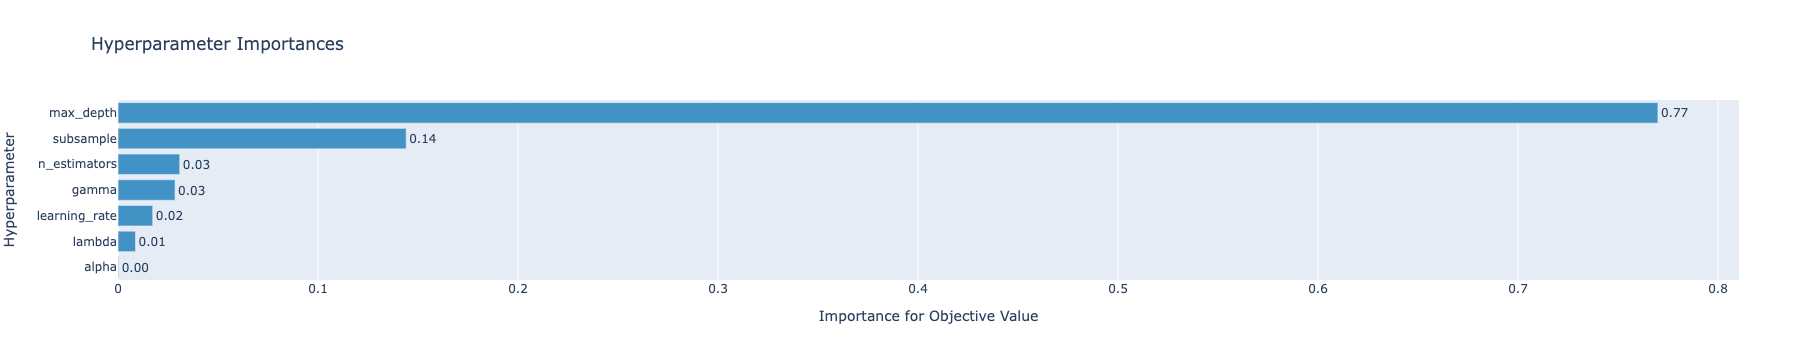

In [57]:
optuna.visualization.plot_param_importances(study)

In [131]:
params = {'n_estimators': 283,
 'max_depth': 10,
 'learning_rate': 0.021323300805309826,
 'subsample': 0.6916311163745187,
 'alpha': 0.0021080949765674923,
 'lambda': 0.013797712639532427,
 'gamma': 0.09234269236795212}

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:25:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


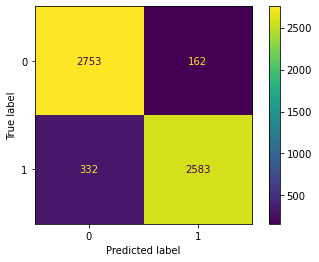

In [67]:
model = XGBClassifier(**params)
model.fit(X, y)
plot_confusion_matrix(model, X, y)
plt.savefig('confuson_matrix.png', dpi=120)

In [76]:
source2.sample(5)

age  height  meld      avg_hr     avg_sbp    avg_dbp    avg_mbp  \
stay_id                                                                     
32985137   80   152.0    27   75.000000  120.545455  70.909091  81.545455   
30579346   93   168.0     9  101.500000  121.000000  58.400000  81.000000   
39215616   84   163.0    26   86.285714  110.142857  60.285714  73.714286   
39123755   91   170.0    14   82.461538  149.230769  67.692308  98.615385   
35295689   64     NaN    10   90.000000   88.500000  57.500000  69.000000   

             avg_rr  avg_temp   avg_spo2  ...  Propofol_200_mg  \
stay_id                                   ...                    
32985137  20.333333    36.530  86.818182  ...                0   
30579346  17.050000    36.060  92.100000  ...                0   
39215616  21.285714    36.440  98.000000  ...                0   
39123755  27.266667    37.134  93.153846  ...                0   
35295689  31.000000       NaN  76.000000  ...                0   

          Propofol_20_mg  Propofol_30_mg  Propofol_40_mg  Propofol_50_mg  \
stay_id                                                                    
32985137               0               0               0               0   
30579346               0               0               0               0   
39215616               0               0               0               0   
39123755               0               0               1               0   
35295689               0               0               0               0   

          Propofol_60_mg  Propofol_70_mg  Propofol_75_mg  Propofol_80_mg  \
stay_id                                                                    
32985137               0               0               0               0   
30579346               0               0               0               0   
39215616               0               0               0               0   
39123755               0               0               0               0   
35295689               0               0               0               0   

               BMI  
stay_id             
32985137  0.743421  
30579346  0.307738  
39215616  0.588344  
39123755  0.441176  
35295689       NaN  

[5 rows x 105 columns]

In [77]:
model = XGBClassifier(**params)
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=1, random_state=1)
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=4, verbose=0)
print('Mean ROC AUC: %.5f' % np.mean(scores))
scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=4, verbose=0)
print('Mean F1: %.5f' % np.mean(scores))
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=4, verbose=0)
print('Mean Accuracy: %.5f' % np.mean(scores))
scores = cross_val_score(model, X, y, scoring='precision', cv=cv, n_jobs=4, verbose=0)
print('Mean Precision: %.5f' % np.mean(scores))
scores = cross_val_score(model, X, y, scoring='recall', cv=cv, n_jobs=4, verbose=0)
print('Mean Recall: %.5f' % np.mean(scores))

Mean ROC AUC: 0.83490
Mean F1: 0.72516
Mean Accuracy: 0.73225
Mean Precision: 0.74488
Mean Recall: 0.70668


In [60]:
import shap

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


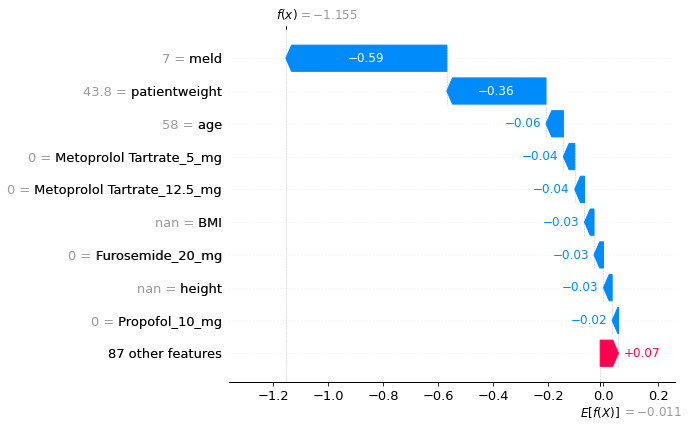

In [61]:
explainer = shap.Explainer(model)
shap_values = explainer(X)
shap.plots.waterfall(shap_values[0], show=False)
plt.savefig(figures_path / 'feature_importance.png', dpi=120)
plt.show()

Note that by default SHAP explains XGBoost classifer models in terms of their margin output, before the logistic link function. That means the units on the x-axis are log-odds units, so negative values imply probabilies of less than 0.5

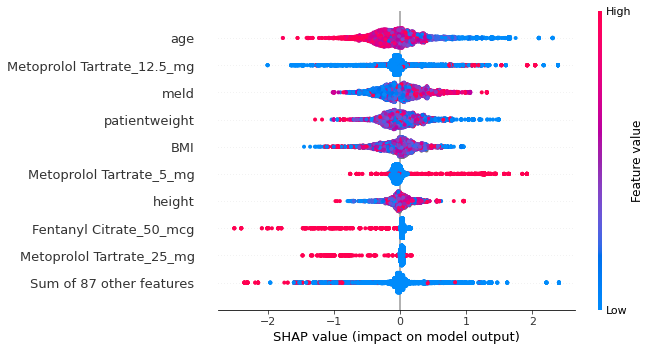

In [69]:
shap.plots.beeswarm(shap_values)

In [78]:
import lightgbm as lgb

In [79]:
X_ = source2.drop(['subject_id', 'avg_hr', 'avg_sbp', 'avg_dbp', 'avg_mbp', 'avg_rr', 'avg_temp', 'avg_spo2', 'avg_glucose'], axis=1)
y_ = source2[['avg_hr', 'avg_mbp', 'avg_rr', 'avg_spo2', 'avg_glucose']].apply(lambda x: get_event(x.avg_hr, x.avg_mbp, x.avg_rr, x.avg_spo2, x.avg_glucose), axis=1)
X, y = under_sampler.fit_resample(X_, y_)

In [102]:
encoded_ptx_drugs

Metoprolol Tartrate  Propofol  NORepinephrine  Furosemide  \
stay_id                                                               
30004391                    1         1               0           1   
30009597                    1         1               0           0   
30010417                    1         0               0           0   
30031418                    0         1               1           0   
30036100                    0         0               0           0   
...                       ...       ...             ...         ...   
39977263                    1         1               0           0   
39988182                    0         1               0           0   
39990055                    1         0               0           1   
39991569                    0         0               0           0   
39992167                    1         0               0           1   

          Lorazepam  Fentanyl Citrate  HYDROmorphone (Dilaudid)  Midazolam  \
stay_id                                                                      
30004391          0                 1                         0          0   
30009597          0                 1                         0          0   
30010417          0                 1                         0          0   
30031418          0                 1                         0          0   
30036100          0                 0                         1          0   
...             ...               ...                       ...        ...   
39977263          0                 1                         1          0   
39988182          0                 1                         0          0   
39990055          0                 0                         0          0   
39991569          0                 1                         0          1   
39992167          0                 0                         0          0   

          Nitroglycerin  PHENYLEPHrine  Haloperidol  
stay_id                                              
30004391              0              1            0  
30009597              0              1            0  
30010417              0              1            0  
30031418              0              0            0  
30036100              0              0            0  
...                 ...            ...          ...  
39977263              0              0            0  
39988182              0              0            0  
39990055              1              0            0  
39991569              0              0            0  
39992167              0              0            0  

[2575 rows x 11 columns]